In [2]:
import perceval as pcvl
from perceval.algorithm import Sampler
from math import pi
from perceval.components import BS, PS

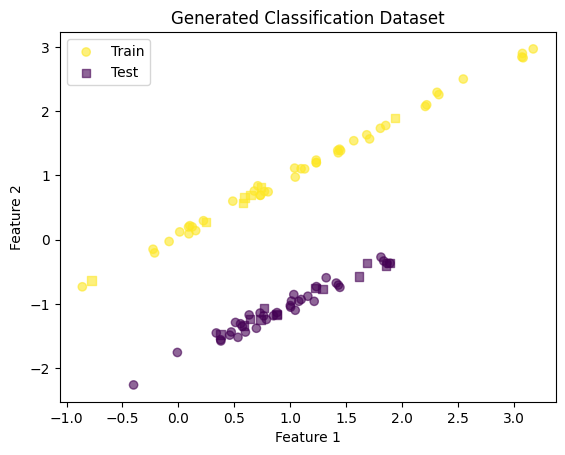

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate dataset with 2 features
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant = 0,random_state=42)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label="Train", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', label="Test", alpha=0.6)
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Classification Dataset")
plt.show()



In [4]:
CNOT = pcvl.catalog["heralded cnot"].build_processor()
def phaseGate(param):
    return pcvl.Circuit(2).add(1, PS(param))
theta = [pcvl.P(f"theta{i}") for i in range(6)]
x = [pcvl.P(f"x{i}") for i in range(3)]

In [15]:
feature_map = pcvl.Processor(pcvl.SLOSBackend(), 4)
ansatz = pcvl.Processor(pcvl.SLOSBackend(), 4)

depth = 2

for i in range(2*depth + 1):
    if i % 2 == 0:
        ansatz.add(0, BS.Ry(theta = theta[i]))
        ansatz.add(2, BS.Ry(theta = theta[i + 1])) 
    else:
        ansatz.add(0,CNOT)

feature_map.add(0, BS.H())
feature_map.add(2, BS.H())
feature_map.add(0, phaseGate(x[0]))
feature_map.add(2, phaseGate(x[1]))
feature_map.add(0, CNOT)
feature_map.add(2, phaseGate(x[2]))
feature_map.add(0, CNOT)

vqc = pcvl.Processor(pcvl.SLOSBackend(), 4)
#vqc.add(0, feature_map)
vqc.add(0, ansatz)

init_state = pcvl.BasicState([1, 0, 1, 0])

def get_probs(params, data):
    x[0].set_value(2*data[0])
    x[1].set_value(2*data[1])
    x[2].set_value(2*(pi - data[0])*(pi - data[0]))
    for i in range(len(params)):
        theta[i].set_value(params[i])
    vqc.with_input(init_state)
    sampler = Sampler(vqc) 
    return sampler.probs()['results']


In [16]:
import pennylane as qml
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np

dev = qml.device("default.qubit", wires = 2)

pennylane_embedding = qml.from_qiskit(ZZFeatureMap(2,1).decompose())
pennylane_ansatz = qml.from_qiskit(RealAmplitudes(2, reps = depth).decompose())

@qml.qnode(dev)
def circuit(x, params):
    #pennylane_embedding(x)
    pennylane_ansatz(params)
    return qml.probs(wires = [0,1])

[0.28678381 0.16174514 0.37123629 0.18023475]
{
  |1,0,1,0>: 0.04920517666045857
  |1,0,0,1>: 0.2924221924612055
  |0,1,1,0>: 0.26666153065319426
  |0,1,0,1>: 0.39171110022514183
}
[0.81659005 0.00961298 0.322175   0.47477385 0.80771018 0.92146463]


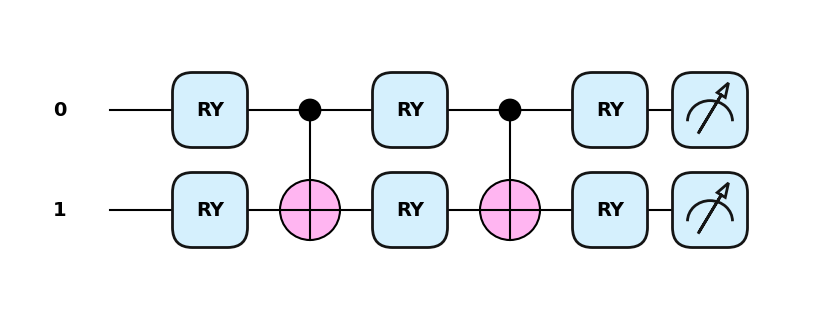

In [17]:
data = X_train[0]
params = np.random.random((6,))
qml.draw_mpl(circuit, style = 'pennylane')(data, params)
print(circuit(data, params))
print(get_probs(params, data))
print(params)

In [ ]:

vqc1 = pcvl.Processor(pcvl.SLOSBackend(), 4)
ansatz1 = pcvl.Processor(pcvl.SLOSBackend(), 4)

depth = 2
for i in range(2*depth + 1):
    if i % 2 == 0:
        ansatz1.add(0, BS.Ry(theta = pcvl.P(f"a{i}")))
        ansatz1.add(2, BS.Ry(theta = pcvl.P(f"a{i + 1}"))) 
    else:
        ansatz1.add(0,CNOT)
a = ansatz1.get_circuit_parameters()
print(a)
vqc1.add(0, ansatz1)
params = [2,1,1,1,1,1]
for i in range(len(params)):
    a[f"a{i}"].set_value(params[i], force=True)
init_state = pcvl.BasicState([1, 0, 1, 0])
vqc1.with_input(init_state)
sampler = Sampler(vqc1)
sampler.probs()

{'a0': Parameter(name='a0', value=None, min_v=0.0, max_v=12.566370614359172), 'a1': Parameter(name='a1', value=None, min_v=0.0, max_v=12.566370614359172), 'a2': Parameter(name='a2', value=None, min_v=0.0, max_v=12.566370614359172), 'a3': Parameter(name='a3', value=None, min_v=0.0, max_v=12.566370614359172), 'a4': Parameter(name='a4', value=None, min_v=0.0, max_v=12.566370614359172), 'a5': Parameter(name='a5', value=None, min_v=0.0, max_v=12.566370614359172)}
